In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu[0])

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# 1. Import Libraries

In [2]:
import re
import math
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from keras.utils import to_categorical
from imblearn.under_sampling import RandomUnderSampler
from tqdm.notebook import tqdm
tqdm.pandas()

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    BatchNormalization, LeakyReLU, Dropout, ReLU, Bidirectional 

from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import  MinMaxScaler, PowerTransformer, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    GradientBoostingClassifier, 
    AdaBoostClassifier, 
    RandomForestClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    StackingClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2. Load Data

In [7]:
data = pd.read_csv('../Dataset/spam.csv', encoding= 'latin-1')
data = data[['class', 'message']]
data

,class,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


# 3. Initial Analysis

### 3.1. Metadata

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   class    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [9]:
data['class'].value_counts()

ham     4825
spam     747
Name: class, dtype: int64

In [21]:
data.isnull().sum()

text     0
label    0
dtype: int64

[Text(0, 0, '4825'), Text(0, 0, '747')]

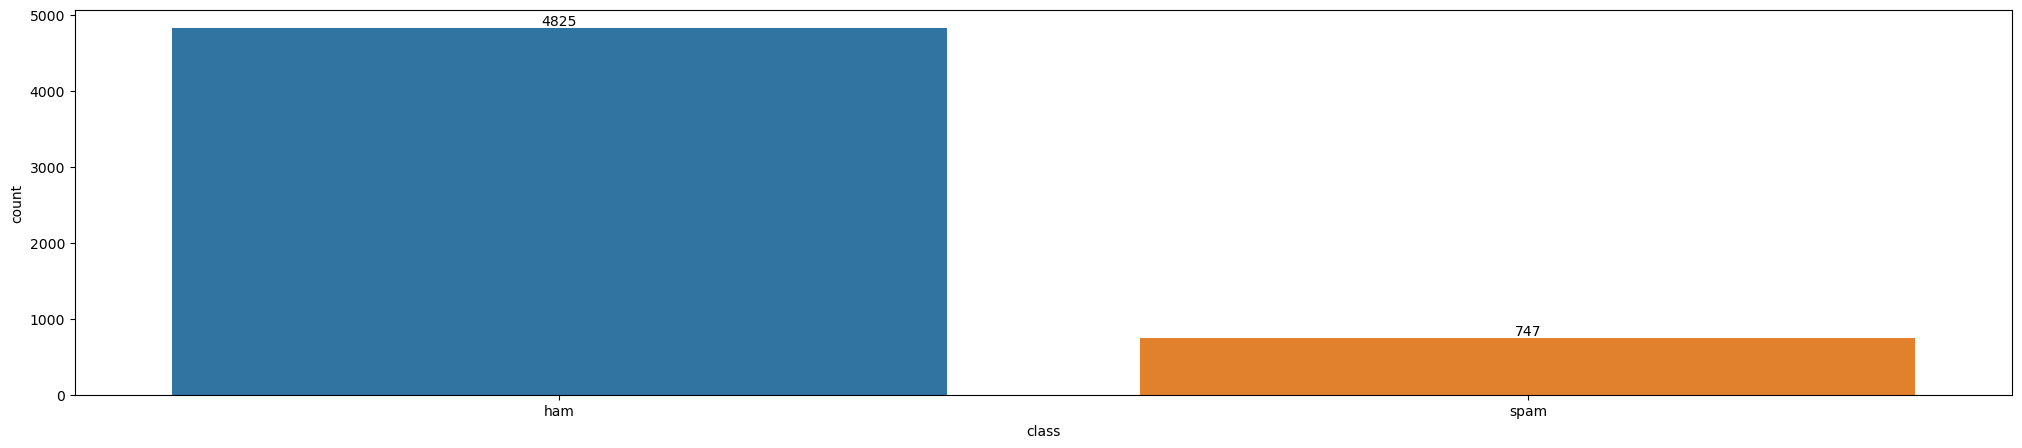

In [10]:
plt.subplots(figsize = (25,5))
ax = sns.countplot(data, x = data['class'])
ax.bar_label(ax.containers[0])

### 3.2. Processing Columns

In [11]:
def lower_text(text):
    return text.lower()

def alphanumeric_text(text):
    # return re.sub("[^a-z0-9\s]","", text)
    text = text.lower()
    return re.sub(r'[^\w\s.,]', '', text)

def remove_duplicate_words(text):
    return re.sub(r'\b(\w+)(\s+\1)+\b', r'\1', text)

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'[^\w\s.,]', '', text)
    text = [word for word in text.split(' ') if word not in nltk_stopword]
    text = " ".join(text)
    # text = [stemmer.stem(word) for word in text.split(' ')]
    # text=" ".join(text)
    return text
lemmatizer = WordNetLemmatizer()

def lemmatize_word(word):
    return lemmatizer.lemmatize(word, pos='v')

def lemmatize_sentence(sentence):
    words = nltk.word_tokenize(sentence)  # convert to lower case and tokenize
    words = [word for word in words if word.isalnum()]  # filter out non-alphanumeric characters
    words = [lemmatize_word(word) for word in words]  # lemmatize each word
    return ' '.join(words)  # join the lemmatized words back into a sentence


stopword_en = pd.read_csv('../../en_stopword_1555.txt', header=None).drop_duplicates()
en_stopword = stopword_en[0].values.tolist()
en_stopword = [word.strip() for word in en_stopword]

nltk_stopword = stopwords.words('english')

combined_stopwords = pd.DataFrame(en_stopword + nltk_stopword).drop_duplicates()
stopword_list = combined_stopwords[0].values.tolist()

In [12]:
data['clean_text'] = data['message'] \
                    .progress_apply(alphanumeric_text) \
                    .progress_apply(clean) \
                    .progress_apply(lemmatize_sentence) \
                    # .progress_apply(remove_duplicate_words) \
                    # .progress_apply(lambda x: ' '.join([word for word in x.split(' ') if word not in (nltk_stopword)])) \
                    # .progress_apply(lower_text) \
                    # .progress_apply(lambda x: ' '.join([word for word in x.split(' ') if len(word) >= 4])) \
                    # .progress_apply(lemmatizer) \
data.head()

  0%|          | 0/5572 [00:00<?, ?it/s]

  0%|          | 0/5572 [00:00<?, ?it/s]

  0%|          | 0/5572 [00:00<?, ?it/s]

,class,message,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts may...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf live around though


<Axes: xlabel='text_len'>

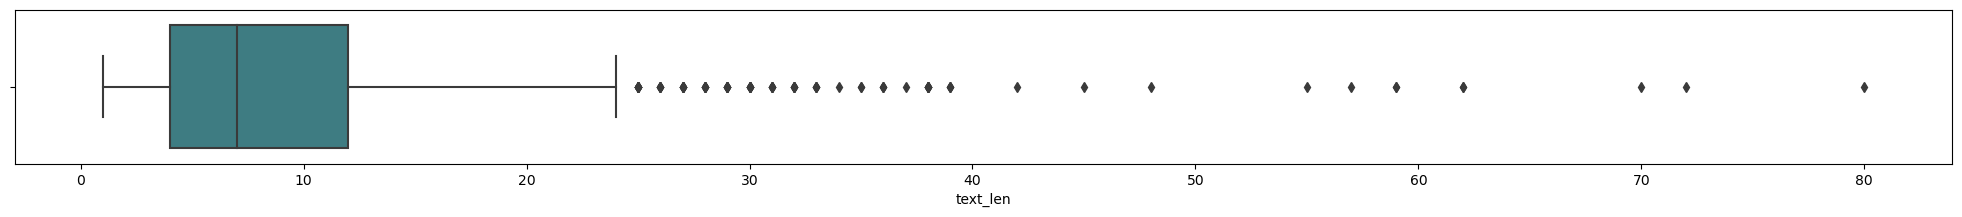

In [13]:
text_len = [len(word) for word in data['clean_text'].str.split(' ')]
data['text_len'] = pd.DataFrame(text_len)

fig, ax = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="crest")

In [14]:
print(data['text_len'].quantile(0.1))
print(data['text_len'].quantile(1))

3.0
80.0


<Axes: xlabel='text_len'>

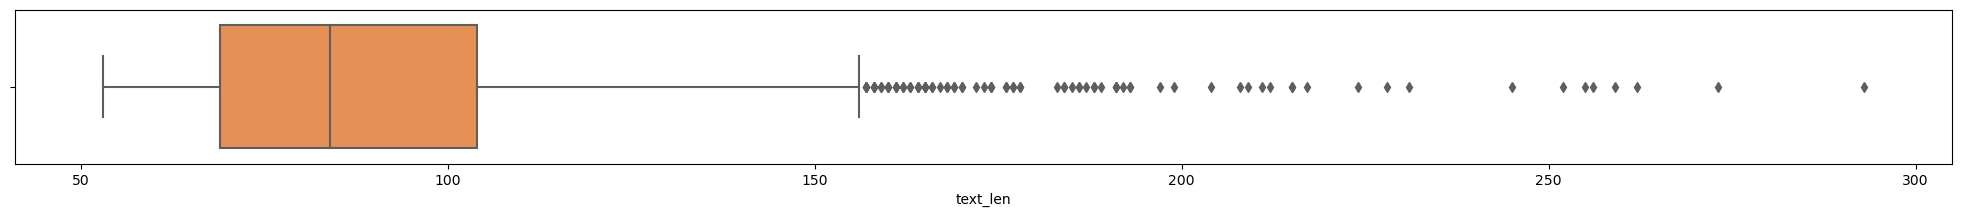

In [8]:
Q1 = data['text_len'].quantile(0.1)
Q3 = data['text_len'].quantile(1)

data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x = data['text_len'], palette="Oranges")

[Text(0, 0, '4825'), Text(0, 0, '747')]

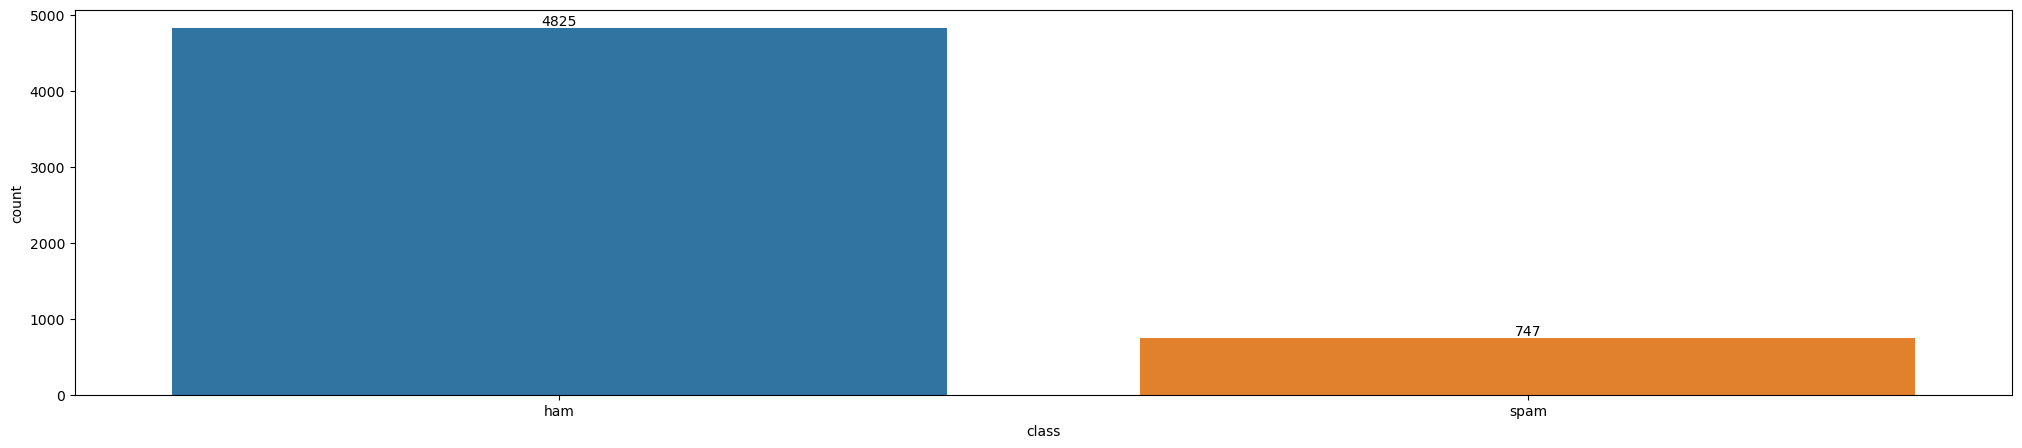

In [15]:
plt.subplots(figsize = (25,5))
ax = sns.countplot(data, x = data['class'])
ax.bar_label(ax.containers[0])

# 4. Preparing Dataset

In [25]:
LE = LabelEncoder()

X = data['clean_text']
# Y = LE.fit_transform(data['label']) ### For Classification Algoritms
Y = pd.get_dummies(data['class']) ### For Deep Learning Algoritms
# Y = data['class'] ### For Deep Learning Algoritms

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(3910,)
(1104,)
(558,)


In [26]:
vocab_size = 7144
embedding_dim = 256
max_length = 80
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [27]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

7143


In [ ]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

# Undersampling
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable

training_padded, training_label = rus.fit_resample(training_padded, training_label)
testing_padded, testing_label = rus.fit_resample(testing_padded, testing_label)
validating_padded, validating_label = rus.fit_resample(validating_padded, validating_label)


# 5. Deep Learning Model

In [33]:
def DNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Flatten())

    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dense(256, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    return model


def CNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling1D())

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling1D())

    model.add(Flatten())
    # model.add(Dense(4098, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dense(256, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Bidirectional(LSTM(256)))
    model.add(Dense(2, activation='softmax'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Bidirectional(GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True)))
    model.add(Bidirectional(GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True)))
    model.add(Dense(2, activation='softmax'))
    return model

# model = DNN_Model()
# model = CNN_Model()
# model = LSTM_Model()
model = GRU_Model()

model.summary()

opt = Adam(learning_rate = 0.0001)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 80, 256)           1828864   
                                                                 
 bidirectional_5 (Bidirectio  (None, 80, 256)          296448    
 nal)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, 512)              789504    
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 2,915,842
Trainable params: 2,915,842
Non-trainable params: 0
_________________________________________________________________


In [34]:
num_epoch = 10
batch_size = 32
history = model.fit(training_padded, training_label, 
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (validating_padded, validating_label))

Epoch 1/20
123/123 [==============================] - 9s 42ms/step - loss: 0.3523 - accuracy: 0.8752 - val_loss: 0.2321 - val_accuracy: 0.9606
Epoch 2/20
123/123 [==============================] - 4s 34ms/step - loss: 0.1088 - accuracy: 0.9726 - val_loss: 0.0782 - val_accuracy: 0.9767
Epoch 3/20
123/123 [==============================] - 4s 34ms/step - loss: 0.0387 - accuracy: 0.9882 - val_loss: 0.0765 - val_accuracy: 0.9785
Epoch 4/20
123/123 [==============================] - 4s 35ms/step - loss: 0.0219 - accuracy: 0.9941 - val_loss: 0.0702 - val_accuracy: 0.9767
Epoch 5/20
123/123 [==============================] - 4s 34ms/step - loss: 0.0118 - accuracy: 0.9964 - val_loss: 0.0792 - val_accuracy: 0.9749
Epoch 6/20
123/123 [==============================] - 4s 34ms/step - loss: 0.0071 - accuracy: 0.9987 - val_loss: 0.0836 - val_accuracy: 0.9695
Epoch 7/20
123/123 [==============================] - 4s 34ms/step - loss: 0.0036 - accuracy: 0.9995 - val_loss: 0.0945 - val_accuracy: 0.9749

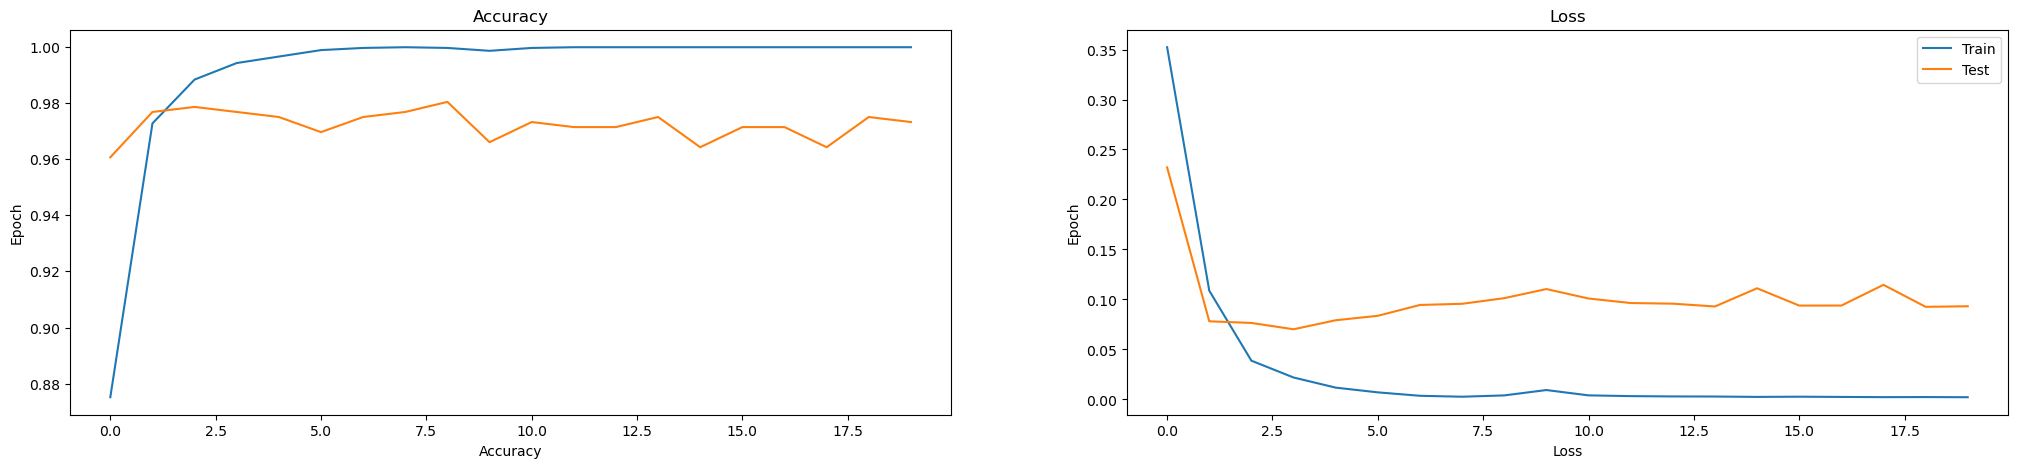

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 5))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [38]:
train_predictions = model.predict(testing_padded, verbose=0).argmax(axis=1)

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':testing_label.argmax(axis=1)})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print(train_results['Diff'].sum(), '/', len(train_results['Diff']))

   Train Predictions  Actuals  Diff
0                  1        1     0
1                  0        1     1
2                  1        1     0
3                  0        0     0
4                  0        0     0
24 / 1104


In [39]:
y_pred = np.rint(model.predict(testing_padded, verbose=0))
print(classification_report(testing_label,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       952
           1       0.94      0.89      0.92       152

   micro avg       0.98      0.98      0.98      1104
   macro avg       0.96      0.94      0.95      1104
weighted avg       0.98      0.98      0.98      1104
 samples avg       0.98      0.98      0.98      1104



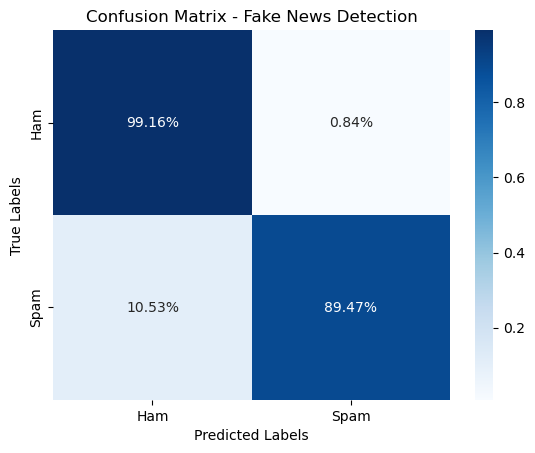

In [45]:
labels = ['Ham','Spam']

y_pred = model.predict(testing_padded, verbose=0).argmax(axis=1)
con_mat = confusion_matrix(testing_label.argmax(axis=1),y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
# sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

In [43]:
model.predict(testing_padded, verbose=0).argmax(axis=1)

array([1, 0, 1, ..., 1, 0, 0], dtype=int64)

# 6. Classification Algoritms

In [96]:
adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
bagging = BaggingClassifier(n_jobs=-1)
extraTrees = ExtraTreesClassifier(max_depth=100, n_jobs=-1, random_state=42)
gradient = GradientBoostingClassifier(max_depth=100, n_estimators=100, learning_rate=.01,  random_state=42)
randomForest = RandomForestClassifier(max_depth=100, random_state=42, n_jobs=-1)
histGradientBoosting = HistGradientBoostingClassifier()
XGB = XGBClassifier(n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
decisionTree = DecisionTreeClassifier(random_state=42, max_depth=100)

model = StackingClassifier([
    ('XGB', XGB),
    ('randomforest', randomForest),
    ('histGradientBoosting', histGradientBoosting),
    # ('adaboost', adaboost),
    # ('bagging', bagging),
    # ('extraTres', extraTrees),
    # ('knn', knn),
    # ('decisionTree', decisionTree),
    # ('gradient', gradient),

], n_jobs=-1)

In [97]:
model.fit(training_padded, training_label)

StackingClassifier(estimators=[('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_...
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=-1,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...)),
                               ('randomforest',
                                RandomForestClassifier(max_depth=100, n_jobs=-1,
                                                       random_state=42)),
                               ('histGradientBoosting',
                                HistGradientBoostingClassifier())],
                   n_jobs=-1)

In [98]:
print("Train Score        :",round((model.score(training_padded, training_label)*100), 2),'%')
print("Test Score         :",round((model.score(testing_padded, testing_label)*100), 2),'%')

y_pred = model.predict(testing_padded)

print("R Squared Error    :",round(r2_score(testing_label, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(testing_label, y_pred), 2))

Train Score        : 99.94 %
Test Score         : 58.37 %
R Squared Error    : -0.68
Mean Squared Error : 0.42


In [99]:
train_predictions = model.predict(testing_padded).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':testing_label})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print(train_results['Diff'].sum(), '/', len(train_results['Diff']))

   Train Predictions  Actuals  Diff
0                  1        0     1
1                  1        1     0
2                  1        1     0
3                  0        0     0
4                  0        1     1
209 / 502


In [100]:
y_pred = model.predict(testing_padded)
print(classification_report(y_pred,testing_label))

              precision    recall  f1-score   support

           0       0.50      0.54      0.52       209
           1       0.65      0.62      0.63       293

    accuracy                           0.58       502
   macro avg       0.58      0.58      0.58       502
weighted avg       0.59      0.58      0.59       502



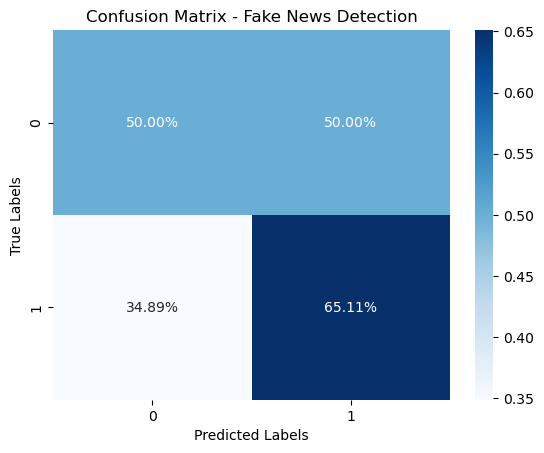

In [101]:
labels = LE.classes_

y_pred = np.rint(model.predict(testing_padded))
con_mat = confusion_matrix(testing_label,y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()